In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA


# 1. Data Gathering

In [49]:
data = pd.read_csv('BigCitiesHealth.csv')

# 2. Data PreProcessing
Handling missing values, removing duplicates, normalizing and scaling values, encoding categorical variables. 

### Dropping not relevant features
Can be because of too many missing values or because it is the same as another one

In [50]:
data = data.drop(['value_90_ci_low', 'value_90_ci_high', 'geo_label_proxy_footnote', 'date_label_proxy_footnote', 'strata_race_sex_label', 
                  'metric_item_label_subtitle', 'metric_source_desc_label_url_fn', 'geo_label_city', 'geo_label_state'], axis=1)

### Normalization of numerical values and encoding for categorical features
First we need to find which colums have which property (numerical/categorical)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148292 entries, 0 to 148291
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   metric_item_label            148292 non-null  object 
 1   metric_cat_label             148292 non-null  object 
 2   metric_subcat_label          148292 non-null  object 
 3   metric_cat_item_yaxis_label  148292 non-null  object 
 4   metric_source_desc_label_fn  148292 non-null  object 
 5   geo_label_citystate          148292 non-null  object 
 6   geo_fips_code                147195 non-null  float64
 7   value                        147522 non-null  float64
 8   date_label                   148292 non-null  int64  
 9   geo_label_proxy_or_real      148292 non-null  object 
 10  geo_fips_desc                148292 non-null  object 
 11  date_label_proxy_or_real     148292 non-null  object 
 12  value_ci_flag_yesno          148292 non-null  object 
 13 

In [52]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns

In [53]:
sc = StandardScaler()

data_standardized = sc.fit_transform(data[num_features])
data_standardized = pd.DataFrame(data_standardized, columns=num_features)

In [54]:
one_hot = OneHotEncoder(sparse=False, drop='if_binary')

data_encoded = one_hot.fit_transform(data[cat_features])
encoded_columns = one_hot.get_feature_names_out(cat_features)
data_encoded = pd.DataFrame(data_encoded, columns=encoded_columns)
data_encoded = data_encoded.iloc[:, :-len(cat_features)]




In [55]:
df = pd.concat([data_encoded, data_standardized], axis=1)
df = pd.DataFrame(df)

In [56]:
df

,metric_item_label_Adult Binge Drinking,metric_item_label_Adult Mental Distress,metric_item_label_Adult Obesity,metric_item_label_Adult Physical Inactivity,metric_item_label_Adult Smoking,metric_item_label_All Cancer Deaths,metric_item_label_Breast Cancer Deaths,metric_item_label_COVID-19 Deaths,metric_item_label_Cardiovascular Disease Deaths,metric_item_label_Child Lead Levels 10+ mcg/dL,...,geo_strata_poverty_Less poor cities (<20% poor),geo_strata_poverty_Poorest cities (20%+ poor),geo_strata_poverty_nan,geo_strata_Population_Largest (>1.3 million),geo_strata_Population_Smaller (<1.3 million),geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.141862,-0.129760,1.533162,-0.131165,-0.127937
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.146574,-0.115337,1.533162,-0.176105,0.029919
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.168956,-0.173087,1.533162,-0.226635,-0.230083
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-0.686952,-0.110544,1.533162,-0.080241,-0.091294
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.033972,-0.149476,1.533162,-0.208797,-0.123201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.453922,1.151422,1.533162,2.983356,2.610736
148288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.574181,1.453856,1.533162,3.436547,3.498188
148289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.151286,0.759500,-1.358382,1.867277,1.911693
148290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.574181,1.132907,-0.394534,2.367062,3.058362


Only missing values in the numerical features. We need to find out if it is better to implement values or to delete rows

In [57]:
df = df.dropna(subset=['value_95_ci_low', 'geo_fips_code'])
df.isnull().sum()

metric_item_label_Adult Binge Drinking         0
metric_item_label_Adult Mental Distress        0
metric_item_label_Adult Obesity                0
metric_item_label_Adult Physical Inactivity    0
metric_item_label_Adult Smoking                0
                                              ..
geo_fips_code                                  0
value                                          0
date_label                                     0
value_95_ci_low                                0
value_95_ci_high                               0
Length: 238, dtype: int64

In [58]:
len(df)

93092

Now there are no more missing values. We went from 148292 to 93092 in data length. 

df is our modified dataframe!

In [59]:
df.dtypes

metric_item_label_Adult Binge Drinking         float64
metric_item_label_Adult Mental Distress        float64
metric_item_label_Adult Obesity                float64
metric_item_label_Adult Physical Inactivity    float64
metric_item_label_Adult Smoking                float64
                                                ...   
geo_fips_code                                  float64
value                                          float64
date_label                                     float64
value_95_ci_low                                float64
value_95_ci_high                               float64
Length: 238, dtype: object

# 3. Exploratory Data Analysis
Goal is to use statistical methods to visualise and find relationships between variable. To find correlations, outliers, patterns etc.

### Heatmap for categorical correlation

In [60]:
corr_matrix = df.corr()

Text(0.5, 1.0, 'Correlation Heatmap')

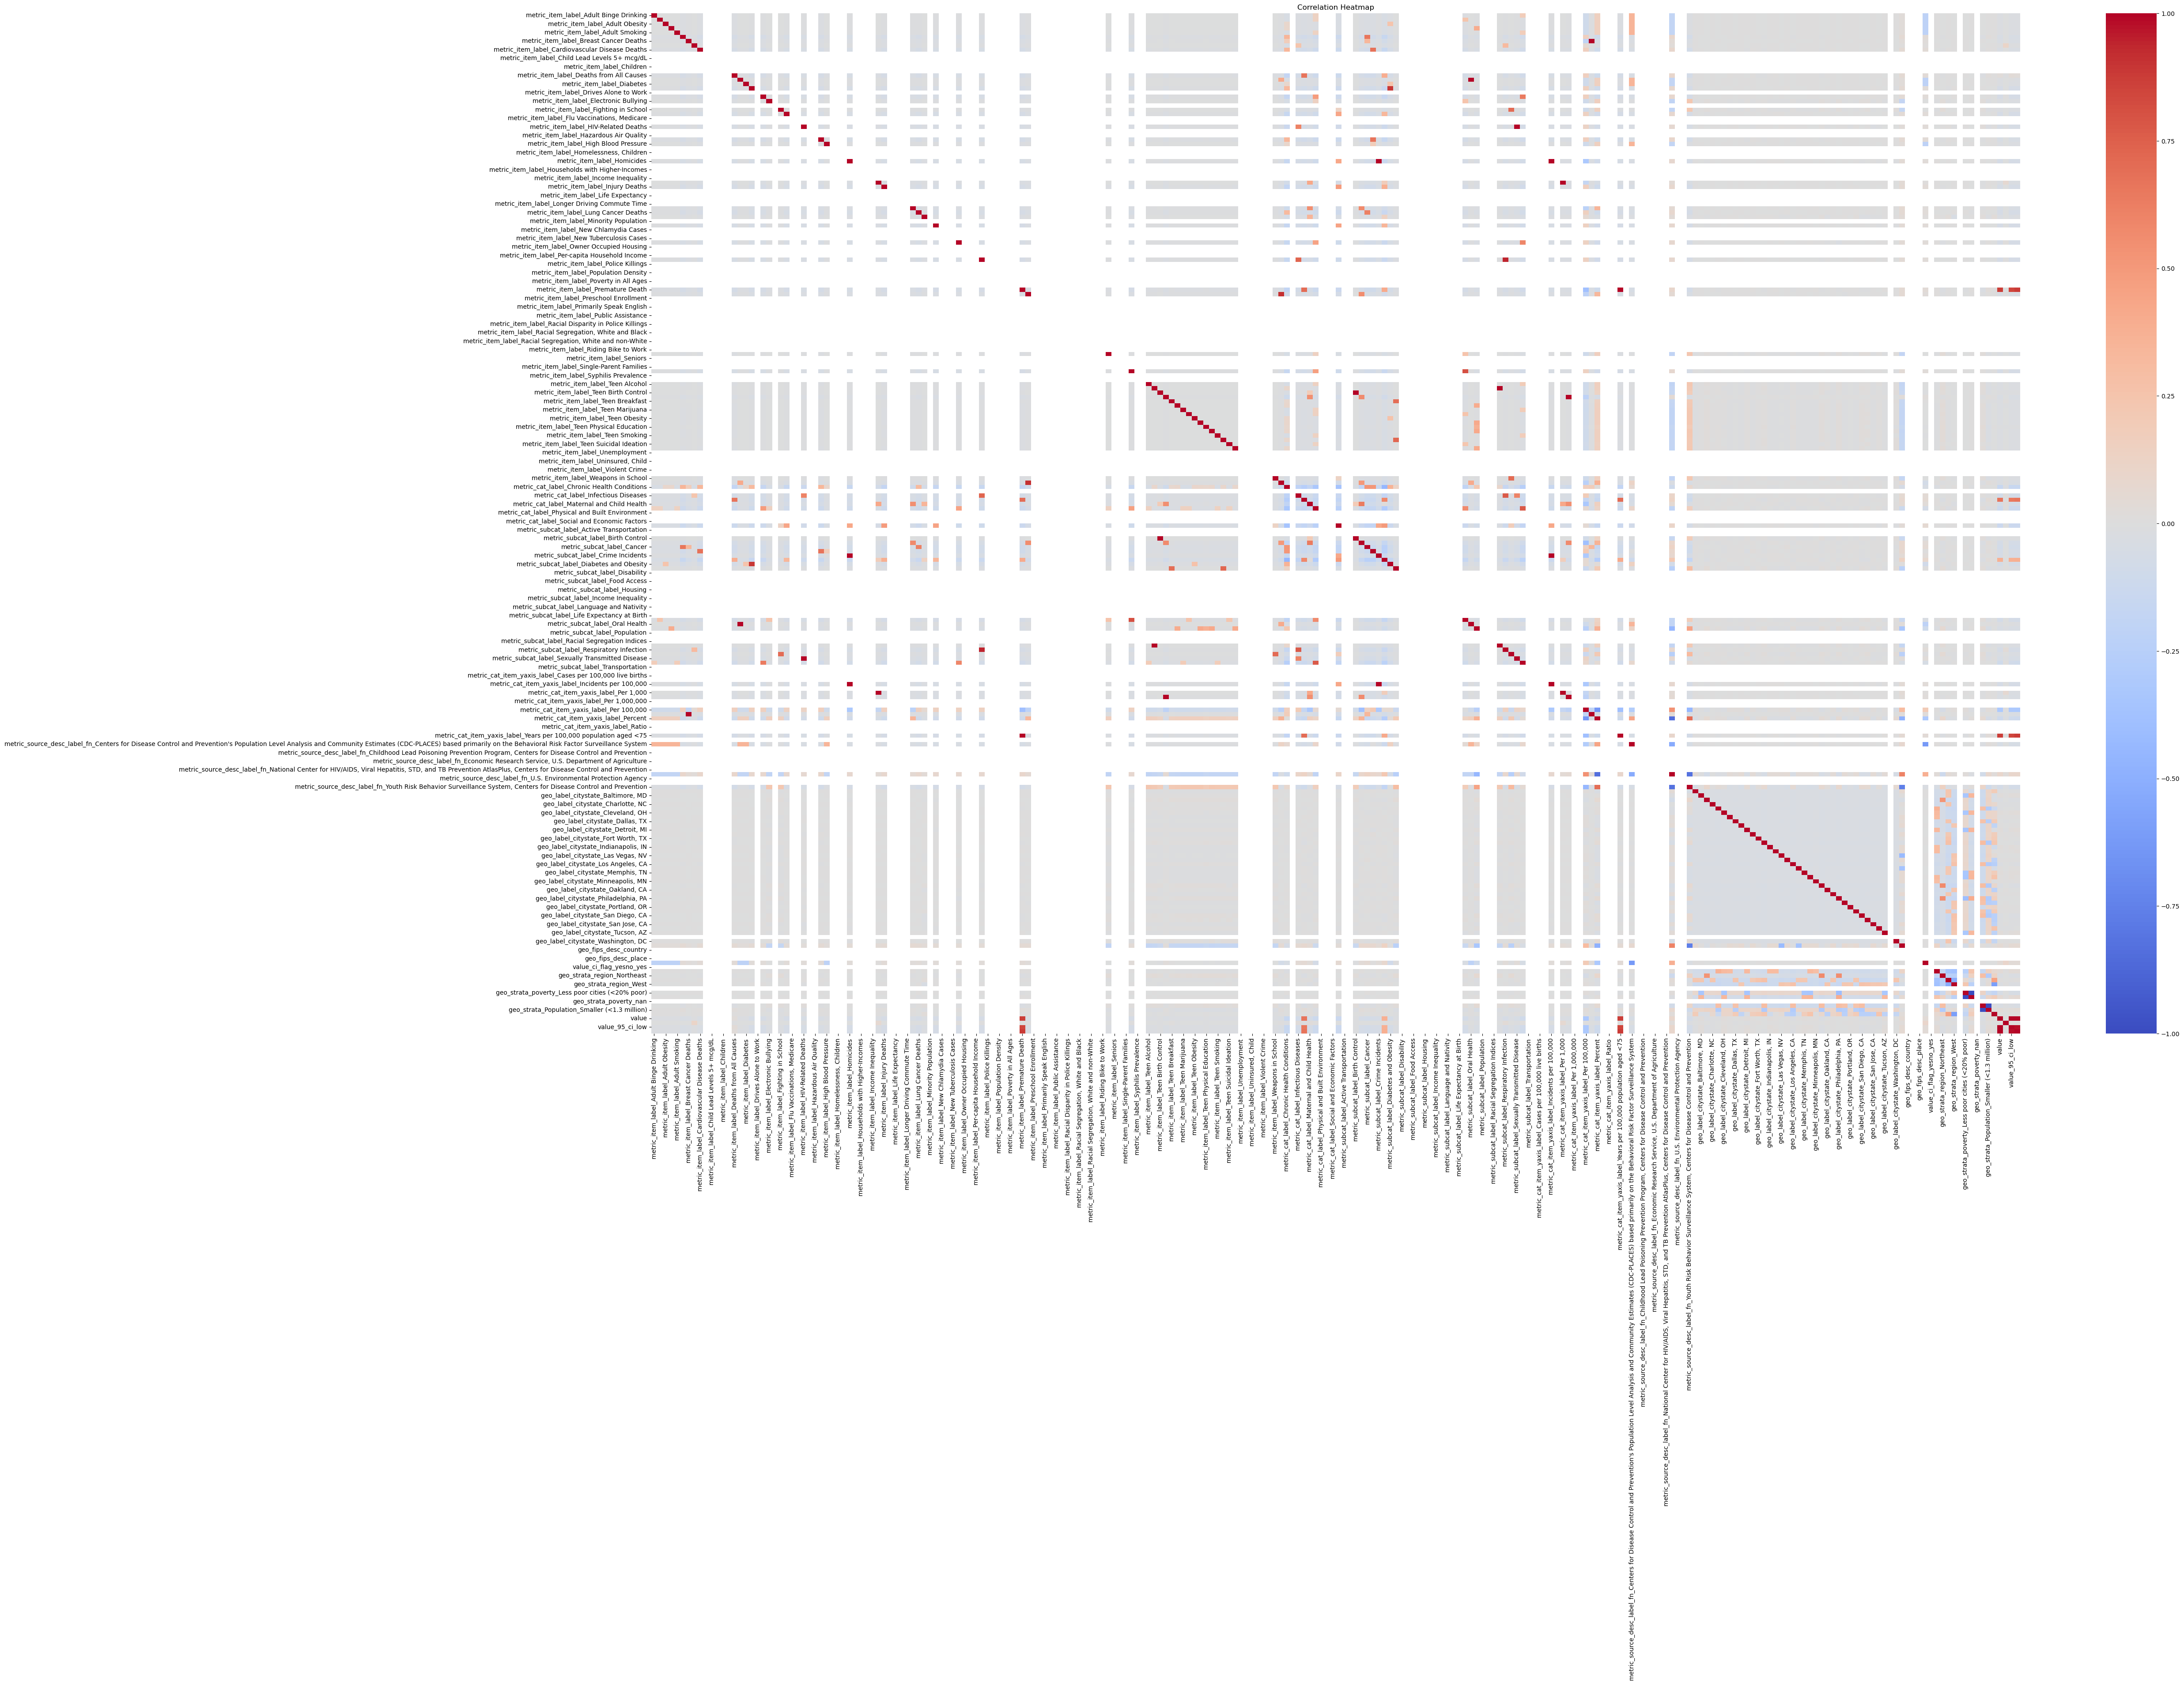

In [61]:
plt.figure(figsize=(50, 30))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', annot_kws={"size": 8})
plt.title('Correlation Heatmap')

### Pearson for numerical only

<AxesSubplot:>

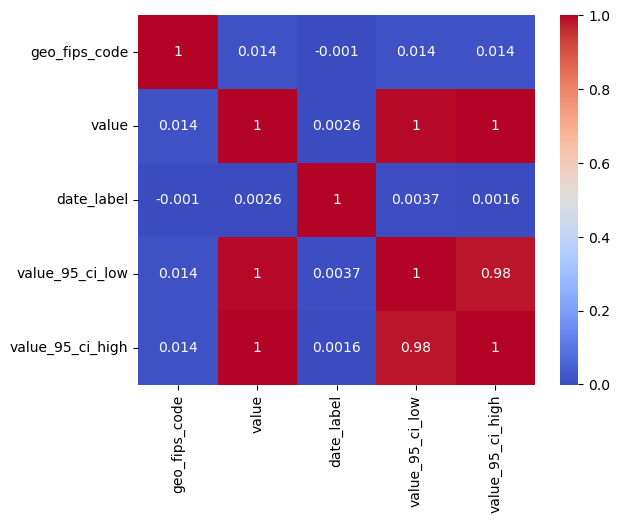

In [62]:
corr_matrix_pearson = df[num_features].corr()
sns.heatmap(corr_matrix_pearson, annot=True, cmap='coolwarm')


# 4. Feature Selection

In [63]:
X = df.drop("metric_item_label_Adult Binge Drinking", axis=1)
y = df['metric_item_label_Adult Binge Drinking']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


### Random Forest

Text(0.5, 1.0, 'Top 15 features selected by Random Forest')

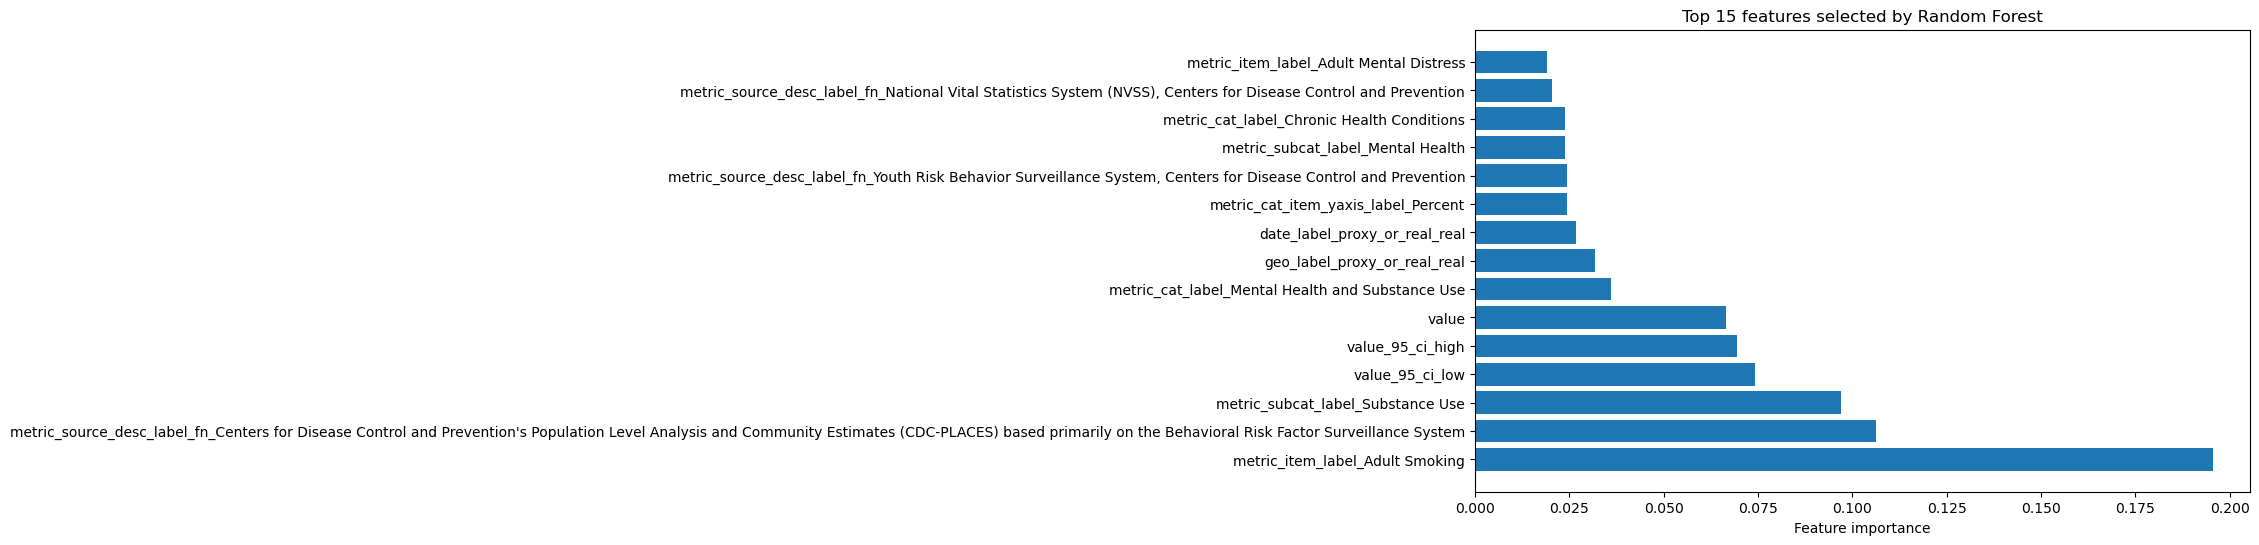

In [65]:
RF = RandomForestClassifier(random_state=43)
RF.fit(X_train, y_train)

importances = RF.feature_importances_
top_indices = importances.argsort()[::-1][:15]
top_features = X_train.columns[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[top_indices])
plt.xlabel('Feature importance')
plt.title('Top 15 features selected by Random Forest')

### Correlation Based Feature Selection

In [73]:
correlation_with_target = corr_matrix['metric_item_label_Adult Binge Drinking'].abs().sort_values(ascending=False)
selected_features = correlation_with_target[:15].index.tolist()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

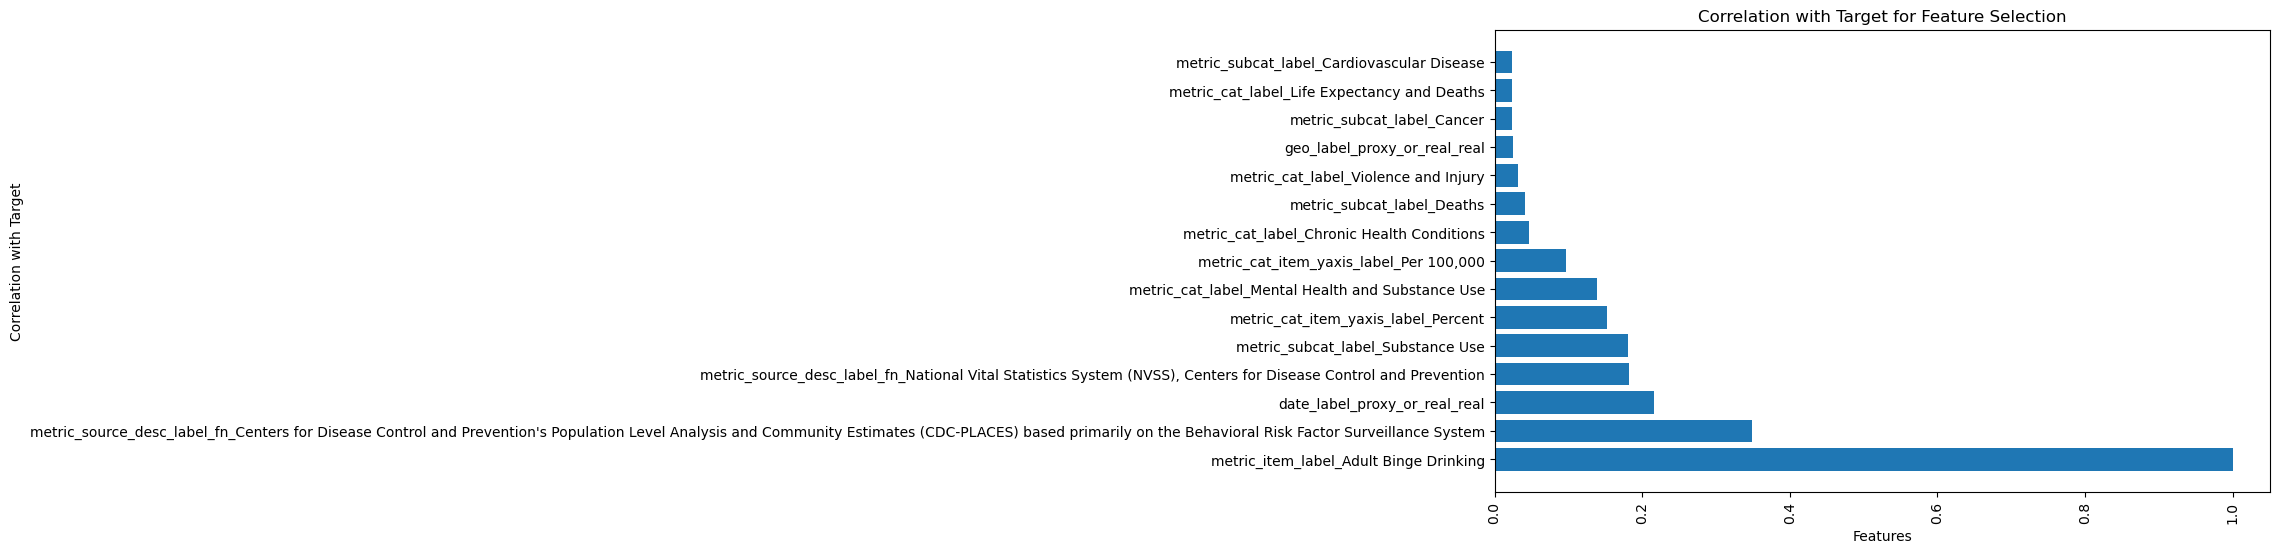

In [74]:
plt.figure(figsize=(10, 6))
plt.barh(selected_features, correlation_with_target[selected_features])
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Correlation with Target for Feature Selection')
plt.xticks(rotation=90)

# 5. Model Selection

# PCA

# 6. Model Training and Evaluation

# 7. Hyperparameter Tuning

# 8. Model Deployment and Monitoring